In [58]:

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, callbacks
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [59]:
df = pd.read_csv('/content/drive/My Drive/LSTMhmmdata.csv', index_col=0)

In [60]:
print(f"Shape du dataset: {df.shape}")
print(f"Colonnes: {df.columns.tolist()}")

Shape du dataset: (3878, 29)
Colonnes: ['volume', 'ADX', 'APO', 'CCI', 'MACD_Signal', 'MACD_Hist', 'OBV', 'RSI', 'SlowD', 'WMA', 'day_var_range', 'Bband_width', 'day_diff', 'ATR', 'day_cos', 'target', 'last_target', 'hmm_state', 'hmm_prob_state_0', 'hmm_prob_state_1', 'hmm_prob_state_2', 'hmm_prob_state_3', 'hmm_prob_state_4', 'hmm_prob_state_5', 'hmm_prob_state_6', 'hmm_entropy', 'hmm_max_prob', 'hmm_state_changed', 'hmm_state_duration']


In [61]:
if 'target' in df.columns:
    print(f"\nDistribution de la target:")
    print(df['target'].value_counts())
    print(f"Ratio: {df['target'].value_counts(normalize=True)}")
else:
    print("\n⚠️ ERREUR: Colonne 'target' non trouvée!")


Distribution de la target:
target
1    2003
0    1875
Name: count, dtype: int64
Ratio: target
1    0.516503
0    0.483497
Name: proportion, dtype: float64


In [62]:
# Séparer features et target
X = df.drop('target', axis=1)
y = df['target'].values

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"Nombre de features: {X.shape[1]}")

# Vérifier les valeurs manquantes
if X.isnull().sum().sum() > 0:
    print(f"\n⚠️ Valeurs manquantes détectées: {X.isnull().sum().sum()}")
    X = X.fillna(method='ffill').fillna(method='bfill')
    print("✓ Valeurs manquantes remplies")

# Remplacer les infinis
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(X.median())


Features shape: (3878, 28)
Target shape: (3878,)
Nombre de features: 28


In [63]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✓ Données normalisées")
print(f"  Mean: {X_scaled.mean():.6f}")
print(f"  Std: {X_scaled.std():.6f}")
print(f"  Min: {X_scaled.min():.6f}")
print(f"  Max: {X_scaled.max():.6f}")


✓ Données normalisées
  Mean: -0.000000
  Std: 1.000000
  Min: -7.120120
  Max: 10.901757


In [64]:
def create_sequences(data, target, sequence_length):
    X_seq = []
    y_seq = []

    for i in range(sequence_length, len(data)):
        # Prendre les sequence_length derniers points
        X_seq.append(data[i-sequence_length:i])
        # Prédire le point suivant
        y_seq.append(target[i])

    return np.array(X_seq), np.array(y_seq)

# Paramètre: longueur de la séquence (lookback)
SEQUENCE_LENGTH = 60  # Utiliser les 60 derniers points pour prédire le suivant

print(f"Longueur de séquence (lookback): {SEQUENCE_LENGTH}")

X_sequences, y_sequences = create_sequences(X_scaled, y, SEQUENCE_LENGTH)

print(f"\n✓ Séquences créées")
print(f"  X_sequences shape: {X_sequences.shape}")
print(f"  y_sequences shape: {y_sequences.shape}")
print(f"  Format: (n_sequences={X_sequences.shape[0]}, lookback={X_sequences.shape[1]}, n_features={X_sequences.shape[2]})")

Longueur de séquence (lookback): 60

✓ Séquences créées
  X_sequences shape: (3818, 60, 28)
  y_sequences shape: (3818,)
  Format: (n_sequences=3818, lookback=60, n_features=28)


In [65]:

# IMPORTANT: Split temporel, pas aléatoire!
# 70% train, 15% validation, 15% test
train_size = int(0.70 * len(X_sequences))
val_size = int(0.15 * len(X_sequences))

X_train = X_sequences[:train_size]
y_train = y_sequences[:train_size]

X_val = X_sequences[train_size:train_size+val_size]
y_val = y_sequences[train_size:train_size+val_size]

X_test = X_sequences[train_size+val_size:]
y_test = y_sequences[train_size+val_size:]

print(f"\n✓ Split temporel effectué:")
print(f"  Train: {X_train.shape[0]} samples ({train_size/len(X_sequences)*100:.1f}%)")
print(f"  Val:   {X_val.shape[0]} samples ({val_size/len(X_sequences)*100:.1f}%)")
print(f"  Test:  {X_test.shape[0]} samples ({(len(X_sequences)-train_size-val_size)/len(X_sequences)*100:.1f}%)")

print(f"\nDistribution train:")
print(f"  Down (0): {(y_train == 0).sum()} ({(y_train == 0).mean()*100:.1f}%)")
print(f"  Up (1):   {(y_train == 1).sum()} ({(y_train == 1).mean()*100:.1f}%)")

print(f"\nDistribution test:")
print(f"  Down (0): {(y_test == 0).sum()} ({(y_test == 0).mean()*100:.1f}%)")
print(f"  Up (1):   {(y_test == 1).sum()} ({(y_test == 1).mean()*100:.1f}%)")


✓ Split temporel effectué:
  Train: 2672 samples (70.0%)
  Val:   572 samples (15.0%)
  Test:  574 samples (15.0%)

Distribution train:
  Down (0): 1288 (48.2%)
  Up (1):   1384 (51.8%)

Distribution test:
  Down (0): 285 (49.7%)
  Up (1):   289 (50.3%)


In [66]:
def build_lstm_model(input_shape, learning_rate=0.001):
    """
    Construit un modèle LSTM pour classification binaire

    Args:
        input_shape: (sequence_length, n_features)
        learning_rate: Taux d'apprentissage

    Returns:
        model: Modèle Keras compilé
    """
    model = keras.Sequential([
        # Première couche LSTM avec return_sequences=True pour empiler
        layers.LSTM(256, return_sequences=True, input_shape=input_shape),
        layers.Dropout(0.3),

        # Deuxième couche LSTM
        layers.LSTM(128, return_sequences=True),
        layers.Dropout(0.3),

        # Troisième couche LSTM (dernière)
        layers.LSTM(64, return_sequences=False),
        layers.Dropout(0.3),

        # Couches denses
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.2),

        layers.Dense(16, activation='relu'),

        # Couche de sortie (classification binaire)
        layers.Dense(1, activation='sigmoid')
    ], name='LSTM_Trading_Model')

    # Compiler le modèle
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )

    return model

In [67]:
input_shape = (X_train.shape[1], X_train.shape[2])  # (sequence_length, n_features)
model = build_lstm_model(input_shape, learning_rate=0.001)

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
model.summary()

print(f"\nNombre total de paramètres: {model.count_params():,}")

Model: "LSTM_Trading_Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 60, 256)        │       291,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 60, 256)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 60, 128)        │       197,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 540,993 (2.06 MB)

 Trainable params: 540,993 (2.06 MB)

 Non-trainable params: 0 (0.00 B)


Nombre total de paramètres: 540,993


In [69]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)

# Réduction du learning rate
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=1e-7,
    verbose=1
)

# Checkpoint pour sauvegarder le meilleur modèle
checkpoint = callbacks.ModelCheckpoint(
    'best_lstm_model.h5',
    monitor='val_auc',
    mode='max',
    save_best_only=True,
    verbose=1
)

callbacks_list = [early_stop, reduce_lr, checkpoint]


In [70]:
class_weight = {
    0: len(y_train) / (2 * (y_train == 0).sum()),
    1: len(y_train) / (2 * (y_train == 1).sum())
}

print(f"\nPoids de classe:")
print(f"  Down (0): {class_weight[0]:.4f}")
print(f"  Up (1):   {class_weight[1]:.4f}")

# Entraîner le modèle
EPOCHS = 100
BATCH_SIZE = 32

print(f"\nDébut de l'entraînement...")
print(f"  Epochs: {EPOCHS}")
print(f"  Batch size: {BATCH_SIZE}")

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weight,
    callbacks=callbacks_list,
    verbose=1
)



Poids de classe:
  Down (0): 1.0373
  Up (1):   0.9653

Début de l'entraînement...
  Epochs: 100
  Batch size: 32
Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.4862 - auc: 0.4799 - loss: 0.7027 - precision: 0.5027 - recall: 0.5085
Epoch 1: val_auc improved from -inf to 0.52337, saving model to best_lstm_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 42s 417ms/step - accuracy: 0.4864 - auc: 0.4801 - loss: 0.7027 - precision: 0.5029 - recall: 0.5084 - val_accuracy: 0.5297 - val_auc: 0.5234 - val_loss: 0.6930 - val_precision: 0.5297 - val_recall: 1.0000 - learning_rate: 0.0010
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.4716 - auc: 0.4673 - loss: 0.7022 - precision: 0.4962 - recall: 0.5685
Epoch 2: val_auc improved from 0.52337 to 0.52436, saving model to best_lstm_model.h5


84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 401ms/step - accuracy: 0.4718 - auc: 0.4676 - loss: 0.7021 - precision: 0.4963 - recall: 0.5684 - val_accuracy: 0.5420 - val_auc: 0.5244 - val_loss: 0.6899 - val_precision: 0.5372 - val_recall: 0.9769 - learning_rate: 0.0010
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step - accuracy: 0.5049 - auc: 0.4901 - loss: 0.6966 - precision: 0.5248 - recall: 0.5748
Epoch 3: val_auc did not improve from 0.52436
84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 398ms/step - accuracy: 0.5049 - auc: 0.4903 - loss: 0.6966 - precision: 0.5249 - recall: 0.5740 - val_accuracy: 0.4738 - val_auc: 0.5143 - val_loss: 0.6948 - val_precision: 0.6250 - val_recall: 0.0165 - learning_rate: 0.0010
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step - accuracy: 0.5016 - auc: 0.5038 - loss: 0.6943 - precision: 0.5138 - recall: 0.5229
Epoch 4: val_auc did not improve from 0.52436
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 394ms/step - accuracy: 0.5016 - auc: 0.5038 - loss: 0.6943 - precision: 0.5138 - recall: 

84/84 ━━━━━━━━━━━━━━━━━━━━ 33s 389ms/step - accuracy: 0.4843 - auc: 0.4974 - loss: 0.6947 - precision: 0.5188 - recall: 0.3812 - val_accuracy: 0.4983 - val_auc: 0.5472 - val_loss: 0.6956 - val_precision: 0.6000 - val_recall: 0.1584 - learning_rate: 0.0010
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - accuracy: 0.5037 - auc: 0.5025 - loss: 0.6954 - precision: 0.5271 - recall: 0.4316
Epoch 6: val_auc did not improve from 0.54719
84/84 ━━━━━━━━━━━━━━━━━━━━ 41s 385ms/step - accuracy: 0.5037 - auc: 0.5024 - loss: 0.6954 - precision: 0.5270 - recall: 0.4315 - val_accuracy: 0.4755 - val_auc: 0.4860 - val_loss: 0.6948 - val_precision: 0.5714 - val_recall: 0.0396 - learning_rate: 0.0010
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.5129 - auc: 0.5008 - loss: 0.6945 - precision: 0.5414 - recall: 0.2544
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 7: val_auc did not improve from 0.54719
84/84 ━━━━━━━━━━━━━━━━━━━━ 34s 403ms/step -

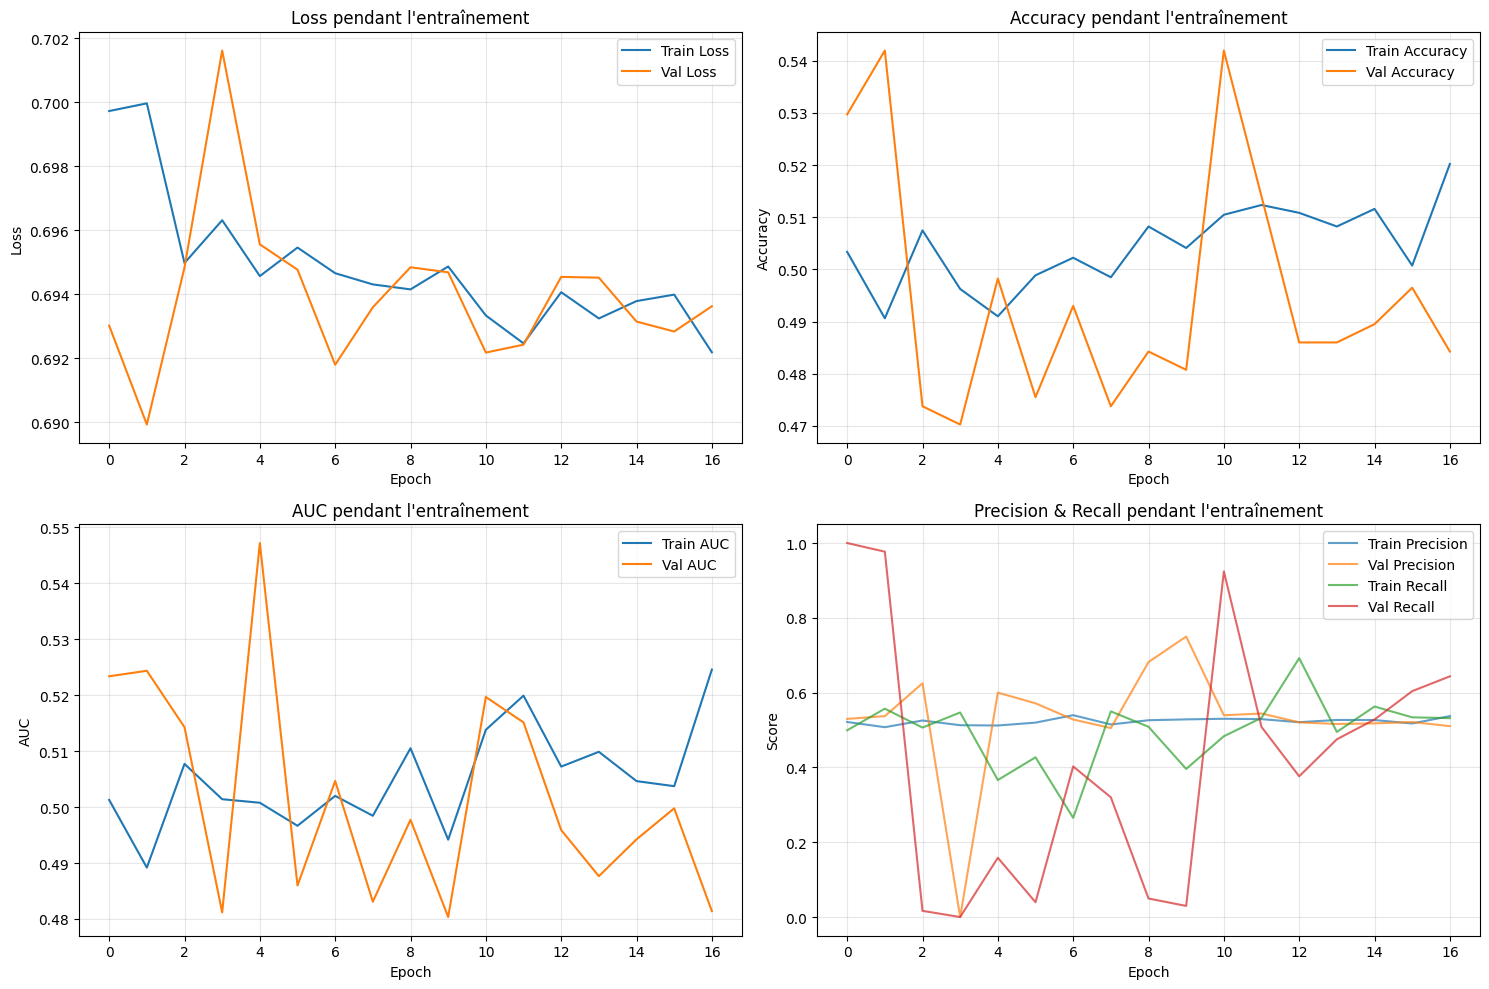

In [71]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history.history['loss'], label='Train Loss')
axes[0, 0].plot(history.history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Loss pendant l\'entraînement')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Accuracy
axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Accuracy pendant l\'entraînement')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# AUC
axes[1, 0].plot(history.history['auc'], label='Train AUC')
axes[1, 0].plot(history.history['val_auc'], label='Val AUC')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('AUC')
axes[1, 0].set_title('AUC pendant l\'entraînement')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Precision & Recall
axes[1, 1].plot(history.history['precision'], label='Train Precision', alpha=0.7)
axes[1, 1].plot(history.history['val_precision'], label='Val Precision', alpha=0.7)
axes[1, 1].plot(history.history['recall'], label='Train Recall', alpha=0.7)
axes[1, 1].plot(history.history['val_recall'], label='Val Recall', alpha=0.7)
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Precision & Recall pendant l\'entraînement')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [72]:
y_pred_proba = model.predict(X_test, verbose=0)
y_pred = (y_pred_proba > 0.5).astype(int).flatten()

In [73]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc_score = roc_auc_score(y_test, y_pred_proba)

print(f"\n📊 RÉSULTATS SUR TEST SET:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")
print(f"  AUC-ROC:   {auc_score:.4f}")

# Classification report détaillé
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Down (0)', 'Up (1)']))


📊 RÉSULTATS SUR TEST SET:
  Accuracy:  0.5244
  Precision: 0.5159
  Recall:    0.8997
  F1-Score:  0.6557
  AUC-ROC:   0.5528

Classification Report:
              precision    recall  f1-score   support

    Down (0)       0.59      0.14      0.23       285
      Up (1)       0.52      0.90      0.66       289

    accuracy                           0.52       574
   macro avg       0.55      0.52      0.44       574
weighted avg       0.55      0.52      0.44       574



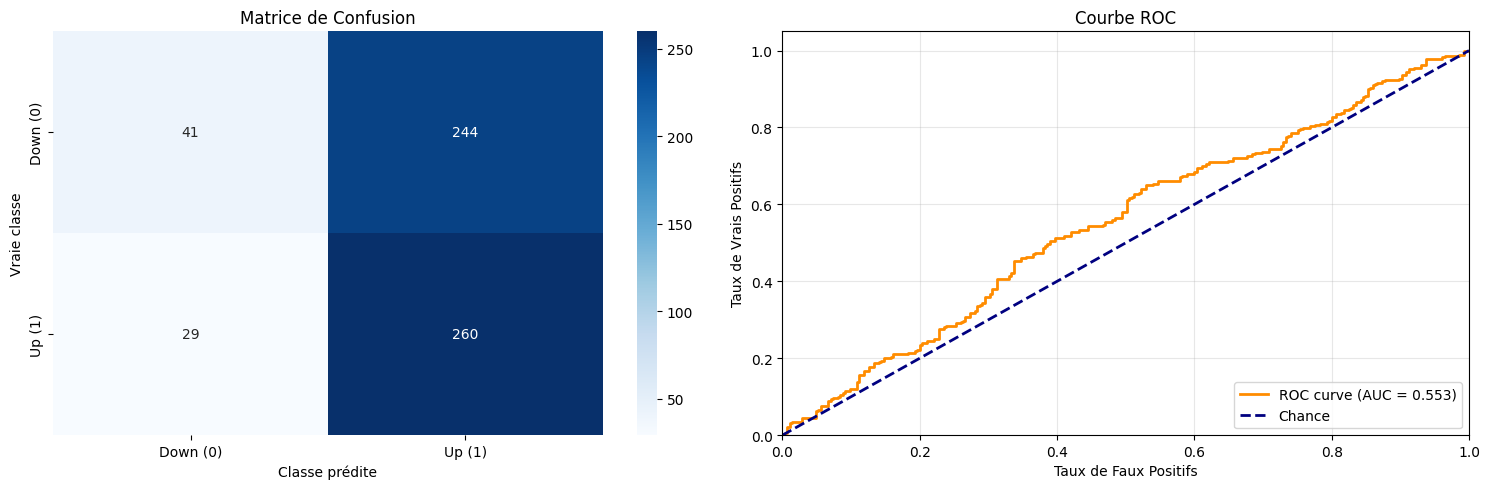

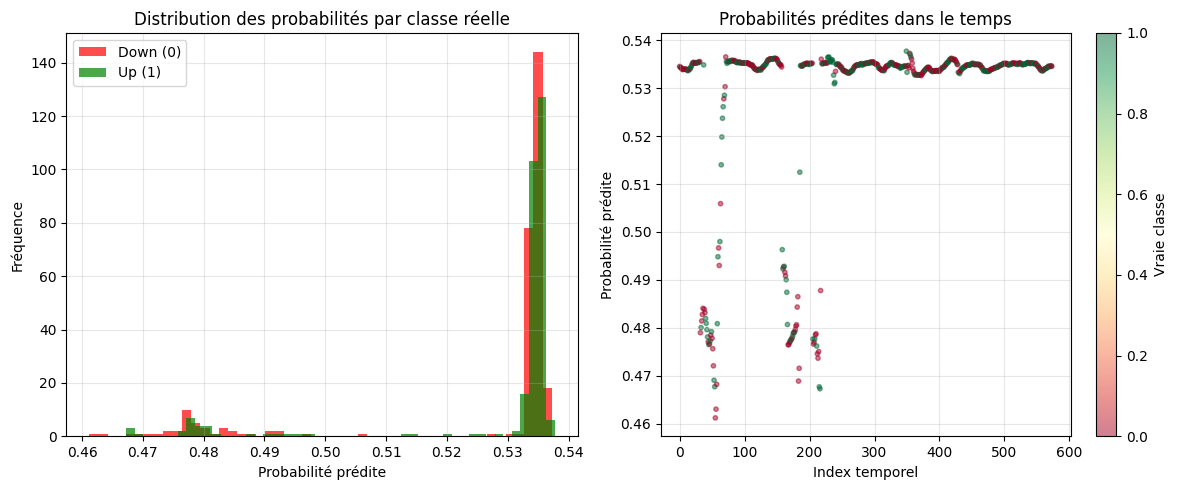

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Down (0)', 'Up (1)'],
            yticklabels=['Down (0)', 'Up (1)'],
            ax=axes[0])
axes[0].set_title('Matrice de Confusion')
axes[0].set_ylabel('Vraie classe')
axes[0].set_xlabel('Classe prédite')

# Courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.3f})')
axes[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance')
axes[1].set_xlim([0.0, 1.0])
axes[1].set_ylim([0.0, 1.05])
axes[1].set_xlabel('Taux de Faux Positifs')
axes[1].set_ylabel('Taux de Vrais Positifs')
axes[1].set_title('Courbe ROC')
axes[1].legend(loc="lower right")
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Distribution des probabilités prédites
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.7, label='Down (0)', color='red')
plt.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.7, label='Up (1)', color='green')
plt.xlabel('Probabilité prédite')
plt.ylabel('Fréquence')
plt.title('Distribution des probabilités par classe réelle')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.scatter(range(len(y_test)), y_pred_proba, c=y_test, cmap='RdYlGn', alpha=0.5, s=10)
plt.xlabel('Index temporel')
plt.ylabel('Probabilité prédite')
plt.title('Probabilités prédites dans le temps')
plt.colorbar(label='Vraie classe')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
